# DEOK Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

color_pal = sns.color_palette()

In [6]:
df = pd.read_csv('./Data/DEOK_hourly.csv')

df.head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


In [7]:
df['Datetime']

0        2012-12-31 01:00:00
1        2012-12-31 02:00:00
2        2012-12-31 03:00:00
3        2012-12-31 04:00:00
4        2012-12-31 05:00:00
                ...         
57734    2018-01-01 20:00:00
57735    2018-01-01 21:00:00
57736    2018-01-01 22:00:00
57737    2018-01-01 23:00:00
57738    2018-01-02 00:00:00
Name: Datetime, Length: 57739, dtype: object

In [8]:
# Set Datetime to a datetime type and put it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])

,DEOK_MW
Datetime,
2012-12-31 01:00:00,2945.0
2012-12-31 02:00:00,2868.0
2012-12-31 03:00:00,2812.0
2012-12-31 04:00:00,2812.0
2012-12-31 05:00:00,2860.0
...,...
2018-01-01 20:00:00,4426.0
2018-01-01 21:00:00,4419.0
2018-01-01 22:00:00,4355.0


In [16]:
df = df.set_index(['Datetime'])

<Axes: xlabel='Datetime'>

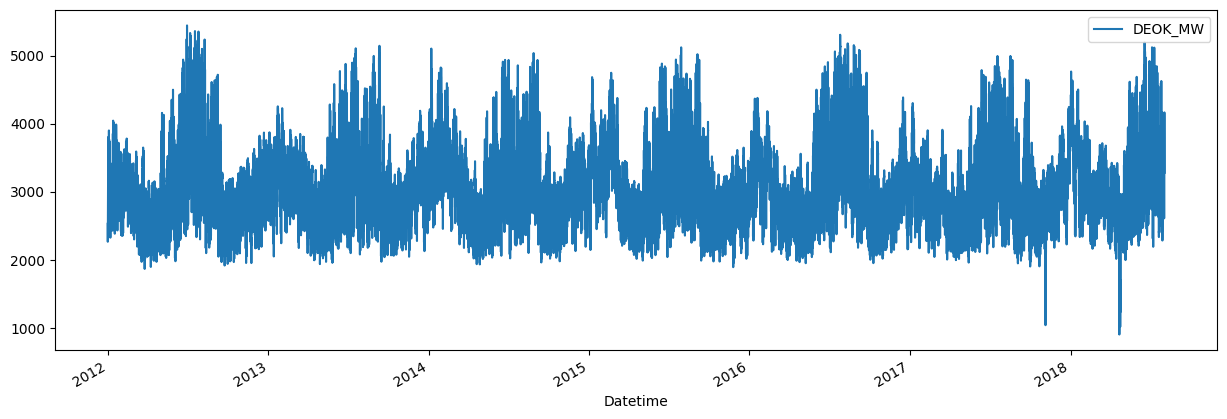

In [17]:
df.plot(figsize=(15,5))

Lets check out a few individual weeks

<Axes: xlabel='Datetime'>

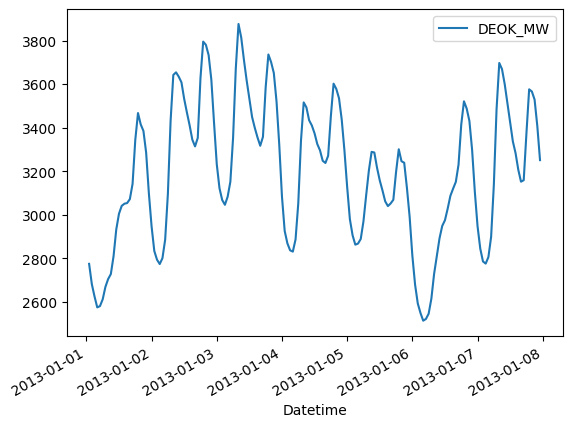

In [18]:
df.loc[(df.index > '2013-01-01') & (df.index < '2013-01-08')].plot()

<Axes: xlabel='Datetime'>

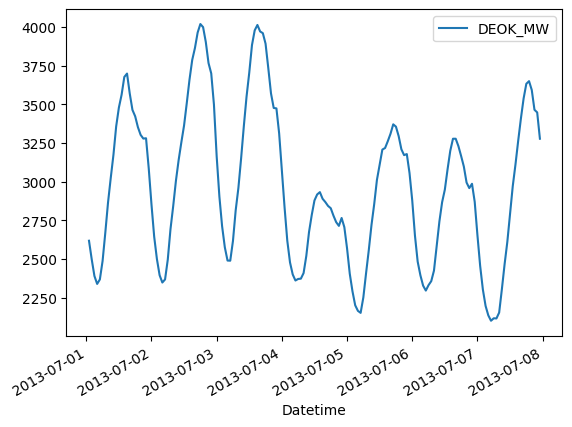

In [19]:
df.loc[(df.index > '2013-07-01') & (df.index < '2013-07-08')].plot()

It looks like there is a big spike during summer months. Let's examine the highest values

In [21]:
df.sort_values('DEOK_MW', ascending=False).head(20)

,DEOK_MW
Datetime,
2012-06-29 16:00:00,5445.0
2012-06-29 15:00:00,5421.0
2012-07-17 18:00:00,5362.0
2012-07-17 17:00:00,5360.0
2012-07-25 17:00:00,5355.0
2012-06-29 14:00:00,5340.0
2012-07-06 18:00:00,5334.0
2012-07-17 19:00:00,5327.0
2012-06-29 17:00:00,5326.0


We can see all of the highest outputs were in June/July of 2012. There are a few from July 2016 as well. We can guess month will be one of the most important features.

# Data splitting

The data ranges from 2012-2018. I'll split the data at 2016.

In [22]:
train_set = df.loc[df.index < '2016-01-01']
test_set = df.loc[df.index >= '2016-01-01']

y_train = train_set['DEOK_MW']
X_train_set = train_set.copy().drop('DEOK_MW', axis=1)

y_test = test_set['DEOK_MW']
X_test_set = test_set.copy().drop('DEOK_MW', axis=1)

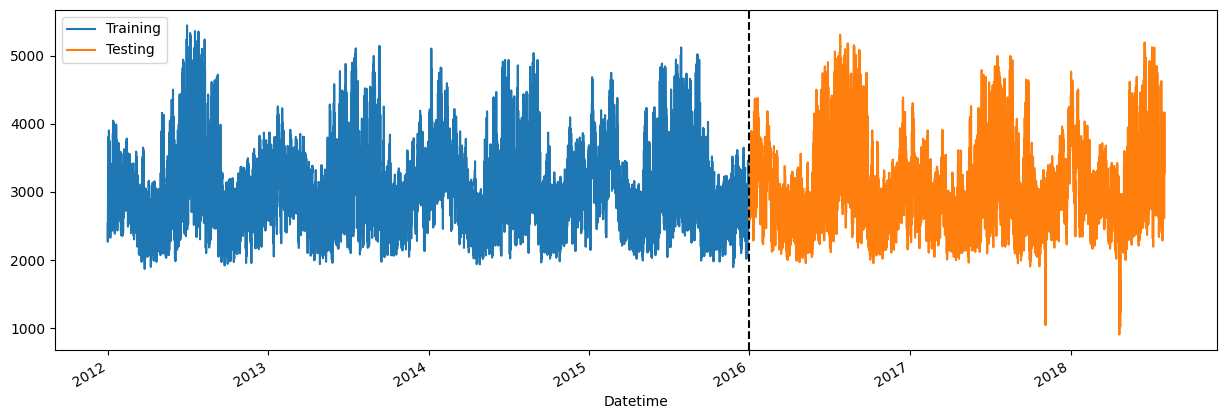

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
train_set.plot(ax = ax, label='Training Set')
test_set.plot(ax = ax, label='Testing Set')
ax.axvline('2016-01-01', color='black', linestyle='--')
ax.legend(['Training','Testing'])
plt.show()

# Create features for modeling

In [32]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    return new_df

# Creating a model

In [33]:
X_train_set_with_features = create_features(X_train_set)
X_test_set_with_features = create_features(X_test_set)

In [38]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.005, early_stopping_rounds=50)

xgb_reg.fit(X_train_set_with_features, y_train, eval_set=[(X_test_set_with_features, y_test)], verbose=50)

[0]	validation_0-rmse:611.30524


[50]	validation_0-rmse:534.79519
[100]	validation_0-rmse:482.03972
[150]	validation_0-rmse:446.33929
[200]	validation_0-rmse:421.75800
[250]	validation_0-rmse:405.79395
[300]	validation_0-rmse:395.12355
[350]	validation_0-rmse:388.13631
[400]	validation_0-rmse:383.62812
[450]	validation_0-rmse:380.87027
[500]	validation_0-rmse:378.76148
[550]	validation_0-rmse:377.01437
[600]	validation_0-rmse:375.91313
[650]	validation_0-rmse:374.95636
[700]	validation_0-rmse:374.50299
[750]	validation_0-rmse:374.55883
[772]	validation_0-rmse:374.59425


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Test the prediction

In [42]:
y_xgb_pred = xgb_reg.predict(X_test_set_with_features)

X_test_with_preds = X_test_set.copy()
X_test_with_preds['actual'] = y_test
X_test_with_preds['prediction'] = y_xgb_pred

X_test_with_preds.head()

,actual,prediction
Datetime,,
2016-01-01 00:00:00,2833.0,3038.542969
2016-12-31 01:00:00,2889.0,2712.477051
2016-12-31 02:00:00,2810.0,2642.755127
2016-12-31 03:00:00,2761.0,2624.415527
2016-12-31 04:00:00,2727.0,2613.852051


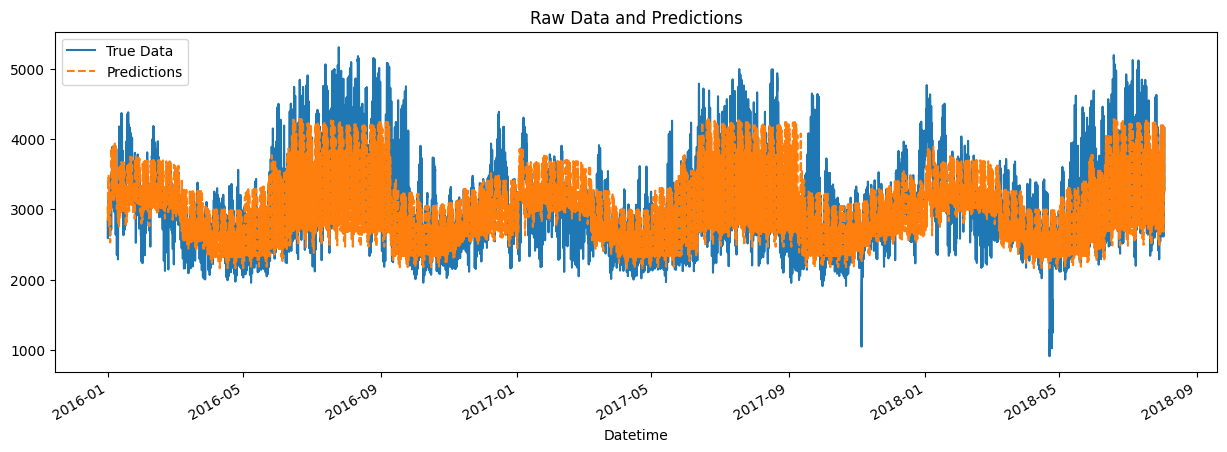

In [45]:
ax = X_test_with_preds[['actual']].plot(figsize=(15,5))
X_test_with_preds['prediction'].plot(ax=ax, style='--')
ax.set_title('Raw Data and Predictions')
plt.legend(['True Data', 'Predictions'])
plt.show()

In [51]:
# Examine importance
feature_imp = pd.DataFrame(data=xgb_reg.feature_importances_, index=xgb_reg.feature_names_in_)

feature_imp

,0
hour,0.539683
dayofweek,0.130290
dayofyear,0.200357
quarter,0.101446
month,0.028224


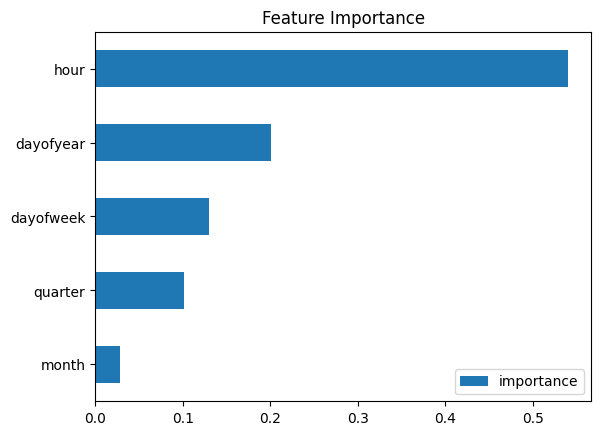

In [52]:
feature_imp.columns = ['importance']

feature_imp.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

We see that hour is the most important feature, which makes sense because energy usage changes throughout the day, however it's quite surprising that month is not being used more. It would appear month is good indicator in our visual analysis, as summer months require significantly more energy than winter ones. I suppose that quarter might be a decent proxy for this.

In [55]:
# Try a new model without quarter
xgb_reg_nq = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.005, early_stopping_rounds=50)

X_train_set_with_features_nq = X_train_set_with_features.drop('quarter', axis=1)
X_test_set_with_features_nq = X_test_set_with_features.drop('quarter', axis=1)

xgb_reg_nq.fit(X_train_set_with_features_nq, y_train, eval_set=[(X_test_set_with_features_nq, y_test)], verbose=50)

[0]	validation_0-rmse:611.30524


[50]	validation_0-rmse:534.79519
[100]	validation_0-rmse:482.03972
[150]	validation_0-rmse:446.33929
[200]	validation_0-rmse:421.75800
[250]	validation_0-rmse:405.79395
[300]	validation_0-rmse:395.12355
[350]	validation_0-rmse:388.13631
[400]	validation_0-rmse:383.62812
[450]	validation_0-rmse:380.87027
[500]	validation_0-rmse:378.76148
[550]	validation_0-rmse:377.01437
[600]	validation_0-rmse:375.91313
[650]	validation_0-rmse:374.95636
[700]	validation_0-rmse:374.50299
[750]	validation_0-rmse:374.55883
[771]	validation_0-rmse:374.58313


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

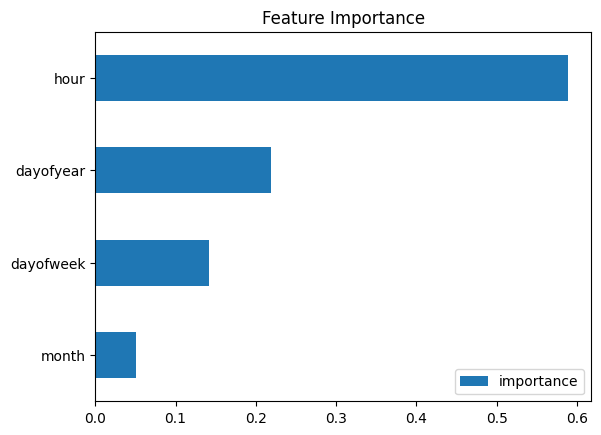

In [56]:
feature_imp_2 = pd.DataFrame(data=xgb_reg_nq.feature_importances_, index=xgb_reg_nq.feature_names_in_)
feature_imp_2.columns = ['importance']

feature_imp_2.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Removing quarter to try to elevate month (to match my own idea) didn't really work. The error and importance ratio is about the same.